# R: Explore Sales Data from Enterprise Systems through Machine Learning

Loading the data from the object storage

In [2]:
#An example of using DSX code insertion features
getObjectStorageFileWithCredentials <- function(container, filename) {
    # This functions returns a textConnection object for a file
    # from Bluemix Object Storage V3.

    if(!require(httr)) install.packages('httr')
    if(!require(RCurl)) install.packages('RCurl')
    library(httr, RCurl)
    auth_url <- paste("https://identity.open.softlayer.com",'/v3/auth/tokens', sep= '')
    auth_args <- paste('{"auth": {"identity": {"password": {"user": {"domain": {"id": ', "9a7ae1a3e8b84f6ea4f35b56b3ae406e",'},"password": ',
                    "H5&9j(pxOV.r^7*K",',"name": ', "admin_026e9a06f554f61b684fe44eb0a70f6960361605",'}},"methods": ["password"]}}}', sep='"')
    auth_response <- httr::POST(url = auth_url, body = auth_args)
    x_subject_token <-  headers(auth_response)[['x-subject-token']]
    auth_body <-  content(auth_response)
    access_url <-  unlist(lapply(auth_body[['token']][['catalog']], function(catalog){
        if((catalog[['type']] == 'object-store')){
            lapply(catalog[['endpoints']], function(endpoints){
                if(endpoints[['interface']] == 'public' && endpoints[['region_id']] == 'dallas') {
                    paste(endpoints[['url']], container, filename, sep='/')}
            })
        }
    }))
    data <- content(httr::GET(url = access_url, add_headers ("Content-Type" = "application/json", "X-Auth-Token" = x_subject_token)), as="text")
    textConnection(data)
}

df <-  read.csv(file = getObjectStorageFileWithCredentials("notebooks", "transactions.csv"))
print('A sample of loaded data')
head(df)

No encoding supplied: defaulting to UTF-8.


[1] "A sample of loaded data"


PRODUCT_LINE,PRODUCT_TYPE,CUST_ORDER_NUMBER,CITY,STATE,COUNTRY,GENDER,AGE,MARITAL_STATUS,PROFESSION
Personal Accessories,Navigation,174344,Plymouth,NA,United Kingdom,M,27,Single,Professional
Personal Accessories,Eyewear,170637,Leipzig,NA,Germany,F,39,Married,Other
Mountaineering Equipment,Rope,170637,Leipzig,NA,Germany,F,39,Married,Other
Personal Accessories,Binoculars,170641,Manaus,BR-AM,Brazil,F,56,Unspecified,Hospitality
Golf Equipment,Woods,170643,College Station,TX,United States,M,45,Married,Retired
Golf Equipment,Irons,170643,College Station,TX,United States,M,45,Married,Retired


## Decision tree-based classification with SparkR and C5.0 library

Transforming the data for using in C5.0

In [3]:
# Preparing the data for training and classification
# Transforming the data frame into matrix
orderDetails <- df
orderDetails$COUNTRY = as.factor(orderDetails$COUNTRY)
orderDetails$GENDER = as.factor(orderDetails$GENDER)
orderDetails$MARITAL_STATUS = as.factor(orderDetails$MARITAL_STATUS)
orderDetails$PROFESSION = as.factor(orderDetails$PROFESSION)
orderDetails$PRODUCT_LINE = as.factor(orderDetails$PRODUCT_LINE)

set.seed(1234)
# training data set
trainingData <- orderDetails


Training the classification model: building model using C50 library

In [4]:
library(C50)
classifierModel <- C5.0(PRODUCT_LINE ~ AGE + GENDER + PROFESSION + MARITAL_STATUS , data=orderDetails, rules=FALSE)

#Detailed textual presentation:
#summary(classifierModel)

### Visualizing the model

Transforming the model for visualization:

In [6]:
library(sigmoml)
library(partykit)
library(plyr)

rulesDataFrame <- sigmoml::getRules(classifierModel)
# replacing NA with an empty string for formatting
# rulesDataFrame[is.na(rulesDataFrame)] <- ""

Graph representation

In [7]:
library(brunel)

brunel (" data('rulesDataFrame') treemap x(Level1, Level2, Level3, Level4, Level5, Level6, Level7, Level8, Level9) color(Prediction) size(Samples) label(Name) filter(Prediction) tooltip(#all)",
        width=1000, height=500, online_js=TRUE)

<!-- ~ Copyright (c) 2015 IBM Corporation and others. ~ ~ Licensed under the Apache License, Version 2.0 (the "License"); ~ You may not use this file except in compliance with the License. ~ You may obtain a copy of the License at ~ ~ http://www.apache.org/licenses/LICENSE-2.0 ~ ~ Unless required by applicable law or agreed to in writing, software ~ distributed under the License is distributed on an "AS IS" BASIS, ~ WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. ~ See the License for the specific language governing permissions and ~ limitations under the License. -->

In [8]:
library(brunel)
brunel (" data('rulesDataFrame') tree(prune:20) y(Level1, Level2, Level3, Level4, Level5, Level6, Level7, Level8, Level9) color(Prediction) label(Prediction) size(samples) tooltip(#all) legends(none)",
        width=1000, height=800, online_js=TRUE)

<!-- ~ Copyright (c) 2015 IBM Corporation and others. ~ ~ Licensed under the Apache License, Version 2.0 (the "License"); ~ You may not use this file except in compliance with the License. ~ You may obtain a copy of the License at ~ ~ http://www.apache.org/licenses/LICENSE-2.0 ~ ~ Unless required by applicable law or agreed to in writing, software ~ distributed under the License is distributed on an "AS IS" BASIS, ~ WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. ~ See the License for the specific language governing permissions and ~ limitations under the License. -->

Native R visualization

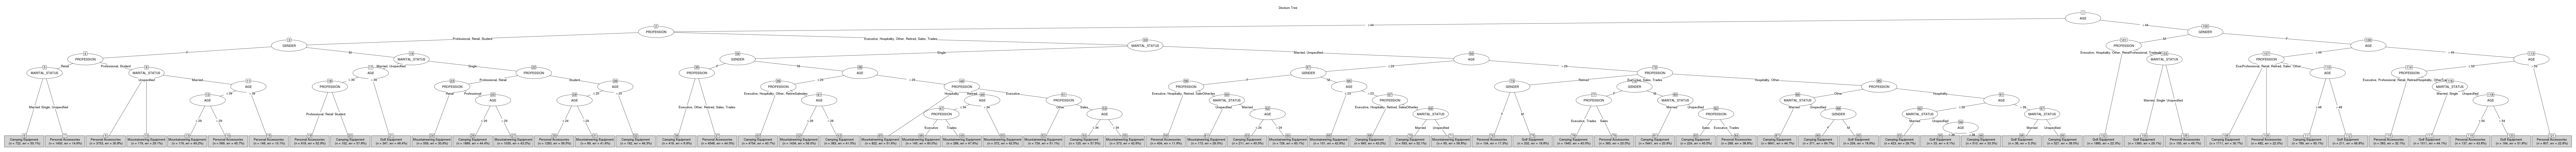

In [9]:
library(repr)

# Change plot size to 136 x 8
options(repr.plot.width=136, repr.plot.height=8)

plot(classifierModel, type="simple",main="Decison Tree", drop_terminal = TRUE)